# FIG 4
## Reconstruction analysis for scan 13

In [1]:
import sys
sys.path.insert(0,'..')

import h5py
import numpy as np
import os
#import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import stempy.io as stio
import stempy.image as stim

from matplotlib.colors import LogNorm

from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

# Better viridis
import matplotlib
viridis2 = matplotlib.colormaps['viridis']
viridis2.set_bad(viridis2.get_under())

In [2]:
# Key files
counted_file = "/global/cfs/cdirs/ncemhub/jrenner1/final/data/counted_gauss_prior_scan0000000013_centered.h5"
counted_file_standard = "/global/cfs/cdirs/ncemhub/jrenner1/final/data/FOURD_241025_1449_20713_00013_centered.h5"

## Study the results of the counting

In [3]:
def virtual_darkfield_inv(array, centers_x, centers_y, radii):
    """Virtual darkfield inverse (same as method from stempy but for r > radii)
    Calculate a virtual dark field image from a set of round virtual apertures in diffraction space.
    Each aperture is defined by a center and radius and the final image is the sum of all of them.
    
    :param array: The SparseArray
    :type array: SparseArray
    
    :param centers_x: The center of each round aperture as the row locations
    :type centers_x: number or iterable
    
    :param centers_y: The center of each round aperture as the column locations
    :type centers_y: number or iterable
    
    :param radii: The radius of each aperture.
    :type radii: number or iterable
    
    :rtype: np.ndarray
    
    :example:
    >>> sp = stempy.io.load_electron_counts('file.h5')
    >>> df2 = stempy.image.virtual_darkfield(sp, (288, 260), (288, 160), (10, 10)) # 2 apertures
    >>> df1 = stempy.image.virtual_darkfield(sp, 260, 160, 10) # 1 aperture
    
    """
    
    # Change to iterable if single value
    if isinstance(centers_x, (int, float)):
         centers_x = (centers_x,)
    if isinstance(centers_y, (int, float)):
         centers_y = (centers_y,)
    if isinstance(radii, (int, float)):
         radii = (radii,)

    rs_image = np.zeros((array.shape[0] * array.shape[1],), dtype=array.dtype)
    for ii, events in enumerate(array.data):
        for ev in events:
            ev_rows = ev // array.frame_shape[0]
            ev_cols = ev % array.frame_shape[1]
            for cc_0, cc_1, rr in zip(centers_x, centers_y, radii):
                dist = np.sqrt((ev_rows - cc_1)**2 + (ev_cols - cc_0)**2)
                rs_image[ii] += len(np.where(dist > rr)[0])
    rs_image = rs_image.reshape(array.scan_shape)
    
    return rs_image

In [4]:
# Load the counted data as sparse arrays
sp_gausscount = stio.load_electron_counts(counted_file)
sp_standard = stio.load_electron_counts(counted_file_standard)

In [5]:
print(f"Frame shape is: {sp_gausscount.frame_shape}; scan shape is {sp_gausscount.scan_shape}")

Frame shape is: (576, 576); scan shape is (512, 513)


In [6]:
# Load the new counted data with weights
with h5py.File(counted_file, 'r') as f0:
    frames_gausscount = f0['electron_events/frames'][:]
    weights_gausscount = f0['electron_events/weights'][:]

<Axes: >

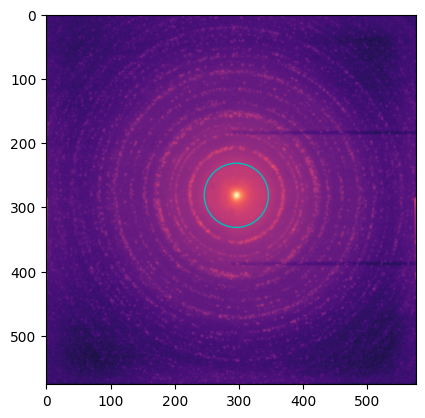

In [7]:
# Set up the parameters to mask the zero-point
mask_zp = True
x0 = 296
y0 = 281
radius = 50

stim.plot_virtual_darkfield(sp_gausscount.sum(axis=(0,1)),(x0),(y0),(radius))

In [8]:
# ----------------------------------------------------------------------------------------------
# Compute the unweighted diffraction pattern sums
dp_standard = sp_standard.sum(axis=(0,1))
dp_gausscount = sp_gausscount.sum(axis=(0,1))
    
# Compute the weighted diffraction pattern sum (need to do the sums manually to include weights)
dp_weighted = np.zeros(sp_gausscount.frame_shape[0]*sp_gausscount.frame_shape[1], np.uint32)
for ii, (events, weights) in enumerate(zip(frames_gausscount, weights_gausscount)):
    dp_weighted[events] += weights
dp_weighted = dp_weighted.reshape(sp_gausscount.frame_shape)

# ----------------------------------------------------------------------------------------------
# Compute the real space sums
rs_weighted = np.zeros(sp_gausscount.scan_shape[0]*sp_gausscount.scan_shape[1], np.uint32)
dp_weighted_masked = np.zeros(sp_gausscount.frame_shape[0]*sp_gausscount.frame_shape[1], np.uint32)
if(mask_zp):
    print("** Masking zero-point!")
    
    rs_standard = virtual_darkfield_inv(sp_standard, (x0), (y0), (radius))
    rs_gausscount = virtual_darkfield_inv(sp_gausscount, (x0), (y0), (radius))
    
    # Loop through all frames to get the corresponding weighted counts
    frame_shape = sp_gausscount.frame_shape
    for ii, (events, weights) in enumerate(zip(frames_gausscount, weights_gausscount)):
        for ev,wt in zip(events,weights):
            ev_row = ev // frame_shape[0]
            ev_col = ev % frame_shape[1]
            dist = np.sqrt((ev_row - y0)**2 + (ev_col - x0)**2)
            if(dist > radius):            
                rs_weighted[ii] += wt
                dp_weighted_masked[ev] += wt
    dp_weighted_masked = dp_weighted_masked.reshape(sp_gausscount.frame_shape)
else:
    
    # Compute the diffraction pattern and real space 
    rs_standard = sp_standard.sum(axis=(2,3))
    rs_gausscount = sp_gausscount.sum(axis=(2,3))

    # Need to do the sums manually to include weights
    for ii, (events, weights) in enumerate(zip(frames_gausscount, weights_gausscount)):
        rs_weighted[ii] = len(events) * sum(weights)

rs_weighted = rs_weighted.reshape(sp_gausscount.scan_shape)

** Masking zero-point!


Setting range 4 to 2932505


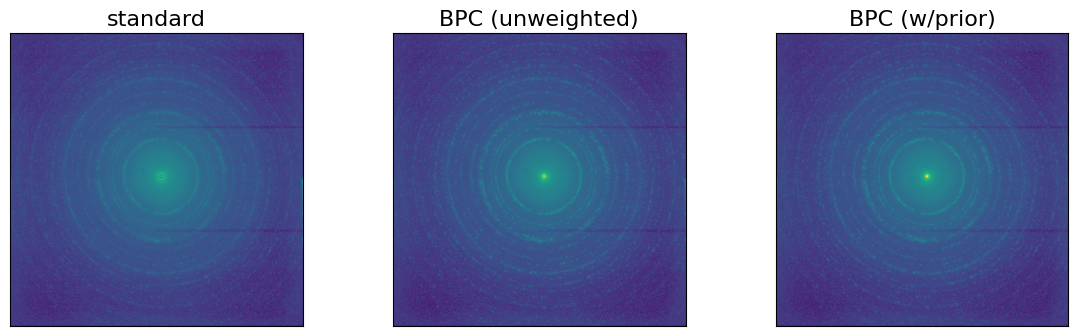

In [18]:
# Plot the diffraction patterns
fig, axes = plt.subplots(1, 3, figsize=(14,3.8))
axs = axes.flatten()

# Labels for each plot
labels_dp = ['a', 'b', 'c']

min_val = np.min([dp_standard, dp_gausscount, dp_weighted])
max_val = np.max([dp_standard, dp_gausscount, dp_weighted])
print(f"Setting range {min_val} to {max_val}")

# ------- standard
im0 = axs[0].imshow(dp_standard, norm=LogNorm(vmin=min_val, vmax=max_val), interpolation="none", cmap=viridis2)
axs[0].set_title("standard",fontsize=16)
#fig.colorbar(im0, ax=axs[0], orientation='vertical')
#axs[0].text(-0.1, 1.15, labels_dp[0], transform=axs[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
# Set up a scale bar
# scale_bar_length = 100  # Length in pixels
# scale_bar_start_x = 50
# scale_bar_start_y = 500
# axs[0].plot([scale_bar_start_x, scale_bar_start_x + scale_bar_length],
#                  [scale_bar_start_y, scale_bar_start_y], color='white', lw=5)
# axs[0].text(scale_bar_start_x + scale_bar_length / 2, scale_bar_start_y + 20, "scale",
#                  color='white', fontsize=14, fontweight="bold", ha='center', va='top')

# ------- new, unweighted
im1 = axs[1].imshow(dp_gausscount, norm=LogNorm(vmin=min_val, vmax=max_val), interpolation="none", cmap=viridis2)
axs[1].set_title("BPC (unweighted)",fontsize=16)
#fig.colorbar(im1, ax=axs[1], orientation='vertical')
#axs[1].text(-0.1, 1.15, labels_dp[1], transform=axs[1].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# ------- new, weighted
im2 = axs[2].imshow(dp_weighted, norm=LogNorm(vmin=min_val, vmax=max_val), interpolation="none", cmap=viridis2)
axs[2].set_title("BPC (w/prior)",fontsize=16)
#fig.colorbar(im2, ax=axs[2], orientation='vertical')
#axs[2].text(-0.1, 1.15, labels_dp[2], transform=axs[2].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
axs[2].xaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

# Save the figure
plt.savefig("fig/fig4_diffraction.svg", bbox_inches='tight')

Found range 0 to 618


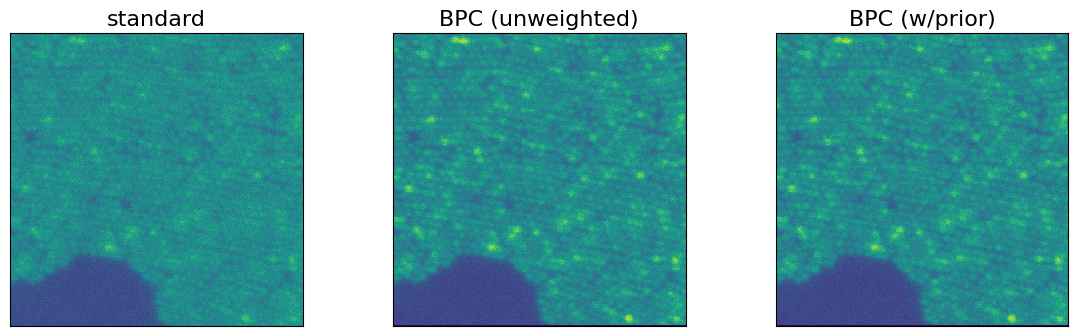

In [45]:
# Plot the bright field images
fig, axes = plt.subplots(1, 3, figsize=(14,3.8))
axs = axes.flatten()

# Labels for each plot
labels_rs = ['d', 'e', 'f']

min_val = np.min([rs_standard, rs_gausscount[:,:-1], rs_weighted[:,:-1]])
max_val = np.max([rs_standard, rs_gausscount[:,:-1], rs_weighted[:,:-1]])
print(f"Found range {min_val} to {max_val}")

# Images are clearer with this max_val (use the same for all images).
max_val = 350

# ------- standard
im0 = axs[0].imshow(rs_standard, interpolation="none", cmap=viridis2, vmin=min_val, vmax=max_val)
axs[0].set_title("standard",fontsize=16)
#fig.colorbar(im0, ax=axs[0], orientation='vertical')
#axs[0].text(-0.1, 1.15, labels_rs[0], transform=axs[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
# Set up a scale bar
# scale_bar_length = 100  # Length in pixels
# scale_bar_start_x = 50
# scale_bar_start_y = 450
# axs[0].plot([scale_bar_start_x, scale_bar_start_x + scale_bar_length],
#                  [scale_bar_start_y, scale_bar_start_y], color='white', lw=5)
# axs[0].text(scale_bar_start_x + scale_bar_length / 2, scale_bar_start_y + 20, "scale",
#                  color='white', fontsize=14, fontweight="bold", ha='center', va='top')

# ------- new, unweighted
im1 = axs[1].imshow(rs_gausscount[:,:-1], interpolation="none", cmap=viridis2, vmin=min_val, vmax=max_val)
axs[1].set_title("BPC (unweighted)",fontsize=16)
#fig.colorbar(im1, ax=axs[1], orientation='vertical')
#axs[1].text(-0.1, 1.15, labels_rs[1], transform=axs[1].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# ------- new, weighted
im2 = axs[2].imshow(rs_weighted[:,:-1], interpolation="none", cmap=viridis2, vmin=min_val, vmax=max_val)
axs[2].set_title("BPC (w/prior)",fontsize=16)
#fig.colorbar(im2, ax=axs[2], orientation='vertical')
#axs[2].text(-0.1, 1.15, labels_rs[2], transform=axs[2].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
axs[2].xaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

# Save the figure
plt.savefig("fig/fig4_realspace.svg", bbox_inches='tight')